In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import scipy.stats
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.graphics.tsaplots as smgt

plt.rcParams["figure.figsize"] = (12,7)

## data uploading

In [2]:
netflix = pd.read_csv("C:/Users/mateu/Desktop/Studia/Semestr 5/Szeregi czasowe/Raport netflix/netflix_prices.csv") 
#C:/Users/mateu/Desktop/Studia/Semestr 5/Szeregi czasowe/Raport netflix/netflix_prices.csv
#C:/Users/wypyc/Desktop/semestr 5/szeregi/raport2/data/netflix_prices.csv

netflix = netflix[["Date","Open"]]
netflix = netflix.set_index("Date")

initial_size = len(netflix)

początek 2014 koniec 2021

Text(0.5, 1.0, 'Wykres zależności ceny otwarcia od czasu')

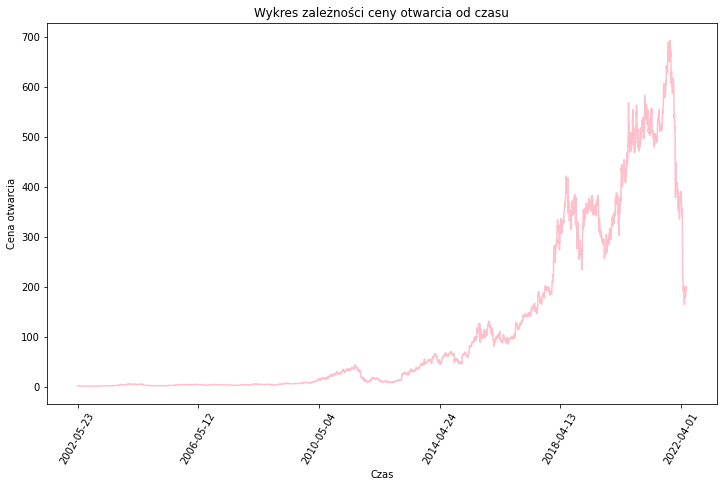

In [3]:
netflix.plot(color = "pink", legend = False)
plt.xlabel("Czas")
plt.ylabel("Cena otwarcia")
plt.xticks(rotation=60)
plt.title("Wykres zależności ceny otwarcia od czasu")

## cut the data

Text(0.5, 1.0, 'Wykres zależności ceny otwarcia od czasu')

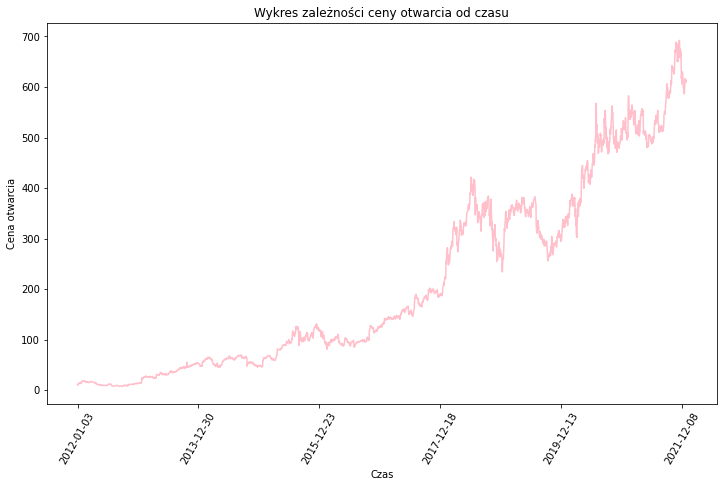

In [4]:
netflix_cut = netflix[netflix.index >= "2012-01-01"]
netflix_cut = netflix_cut[netflix_cut.index <= "2021-12-31"]
initial_cut_size = len(netflix_cut)

netflix_cut.plot(color = "pink", legend = False)
plt.xlabel("Czas")
plt.ylabel("Cena otwarcia")
plt.xticks(rotation=60)
plt.title("Wykres zależności ceny otwarcia od czasu")

## working on missing dates

In [5]:
#change string into datetime type
netflix.index = pd.to_datetime(netflix.index)

#all dates between two ones
all_dates = pd.date_range(netflix.index[0],netflix.index[-1])

#all except these in netflix dataframe
no_netflix_dates = all_dates.difference(netflix.index)

# add missing dates to existing netflix datafra
netflix = netflix.reindex(all_dates, fill_value = 0) #any missing values in the series are filled with 0

In [6]:
len(no_netflix_dates)

2273

In [7]:
len(netflix)

7317

In [8]:
latter_size = len(netflix)
latter_size

print(initial_size,latter_size, latter_size - initial_size)

5044 7317 2273


In [9]:
netflix.Open.value_counts()[0] == latter_size - initial_size ## 0 is only for previous missing values

True

In [10]:
MA_netflix = netflix
MA_netflix["Open"] = MA_netflix["Open"].rolling(30).mean()
MA_netflix
len(MA_netflix)

7317

<AxesSubplot:>

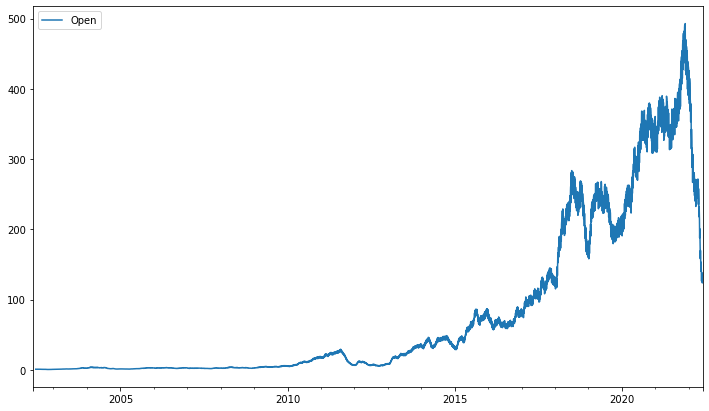

In [11]:
MA_netflix.plot()

In [12]:
MA_cut_netflix = MA_netflix[MA_netflix.index >= "2012-01-01"]
MA_cut_netflix = MA_cut_netflix[MA_cut_netflix.index <= "2021-12-31"]
latter_cut_size = len(MA_cut_netflix)
latter_cut_size

3653

In [13]:
no_MA_cut = netflix[netflix.index >= "2012-01-01"]
no_MA_cut = no_MA_cut[no_MA_cut.index <= "2021-12-31"]
len(no_MA_cut)

3653

In [14]:
print(initial_cut_size, latter_cut_size, latter_cut_size - initial_cut_size)

2517 3653 1136


In [15]:
for i in range(len(no_MA_cut)):
    if no_MA_cut.Open[i] == 0:
        no_MA_cut.Open[i] = MA_cut_netflix.Open[i] 

In [16]:
no_MA_cut.head()

,Open
2012-01-01,6.375476
2012-01-02,6.375476
2012-01-03,6.710143
2012-01-04,6.735857
2012-01-05,6.780333


<AxesSubplot:>

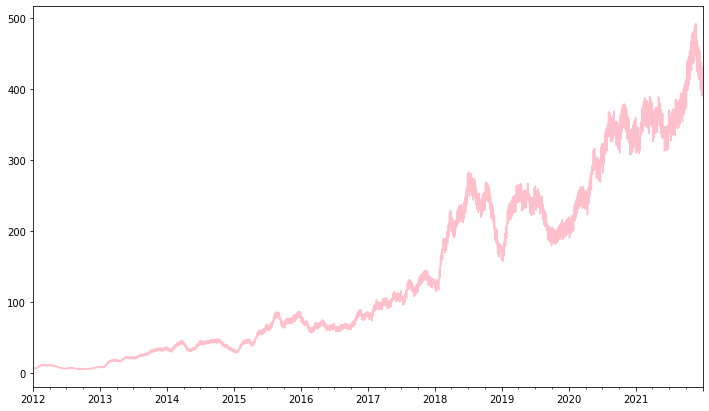

In [17]:
no_MA_cut.plot(color = "pink", legend = False)

## training and testing dataset

In [18]:
training = no_MA_cut[:-300]
test = no_MA_cut[-300:]

Text(0.5, 1.0, 'Wykres zależności ceny otwarcia od czasu dla zbioru treningowego')

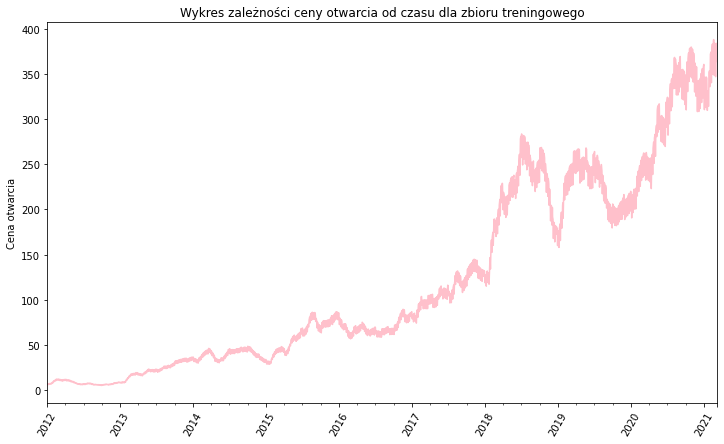

In [19]:
training.plot(color = "pink", legend = False)
plt.ylabel("Cena otwarcia")
plt.xticks(rotation=60)
plt.title("Wykres zależności ceny otwarcia od czasu dla zbioru treningowego")

## ACF i PACF dla niestacjonarnego

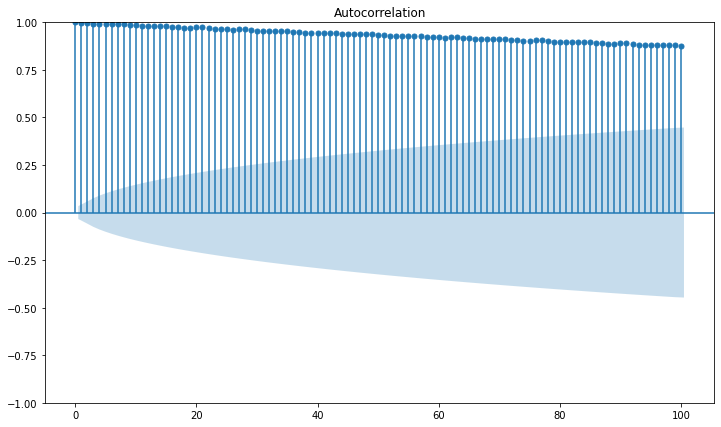

In [103]:
smgt.plot_acf(training, lags = 100);
plt.savefig("acf_training.pdf", bbox_inches='tight')

C:\Users\mateu\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


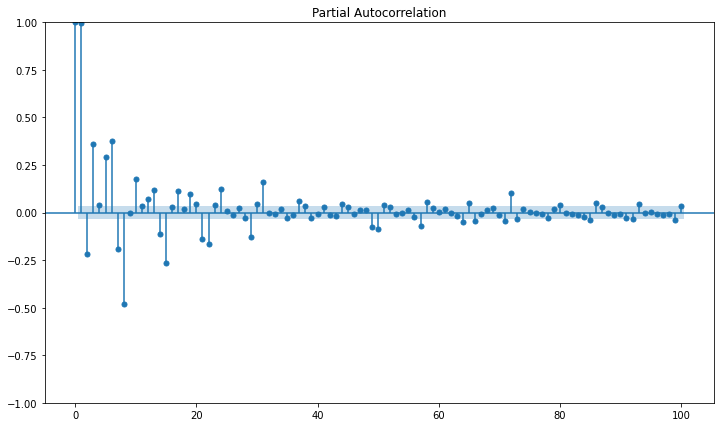

In [102]:
smgt.plot_pacf(training, lags = 100);
plt.savefig("pacf_training.pdf", bbox_inches='tight')

In [105]:
adfuller(training)

(-0.07362024466120841,
 0.952003490223564,
 29,
 3323,
 {'1%': -3.4323194127755112,
  '5%': -2.862410170862447,
  '10%': -2.5672332095457397},
 13935.897277055614)

# Dekompozycja

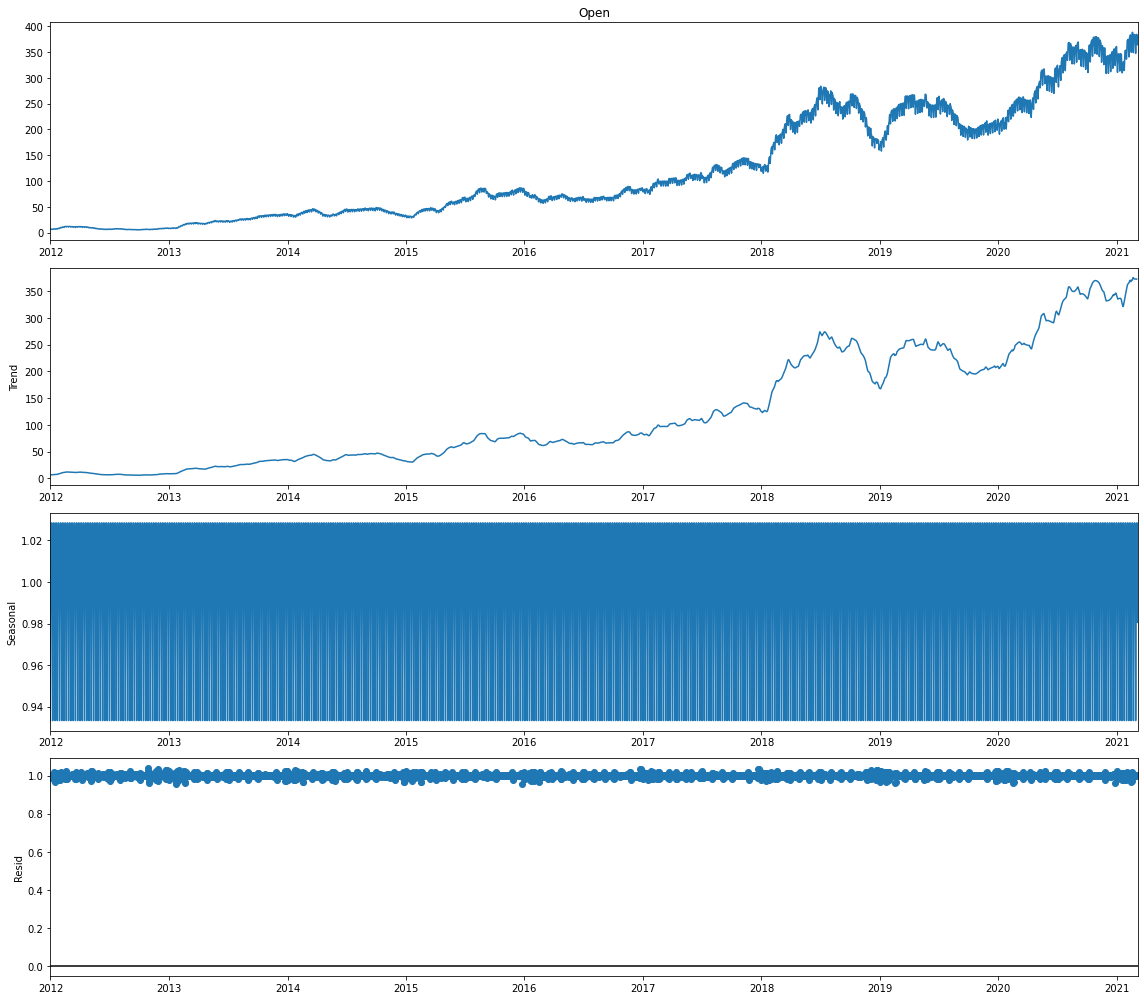

In [20]:
plt.rcParams["figure.figsize"] = (16,14)
decompose_result = seasonal_decompose(training["Open"], model="multiplicative")
decompose_result.plot();
plt.rcParams["figure.figsize"] = (12,7)

plt.savefig("decomposition.pdf", bbox_inches='tight')

In [21]:
seasonal = decompose_result.seasonal
seasonal

2012-01-01    0.933279
2012-01-02    0.976732
2012-01-03    1.024241
2012-01-04    1.028475
2012-01-05    1.028442
                ...   
2021-03-02    1.024241
2021-03-03    1.028475
2021-03-04    1.028442
2021-03-05    1.028237
2021-03-06    0.980594
Freq: D, Name: seasonal, Length: 3353, dtype: float64

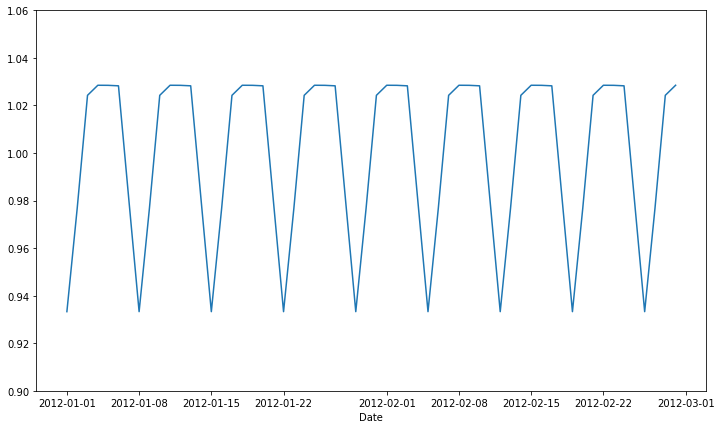

In [22]:
plt.plot(seasonal.index[0:60], seasonal[0:60])
plt.ylim([0.9,1.06])
plt.xlabel("Date")

plt.savefig("seasonal_month.pdf", bbox_inches='tight')

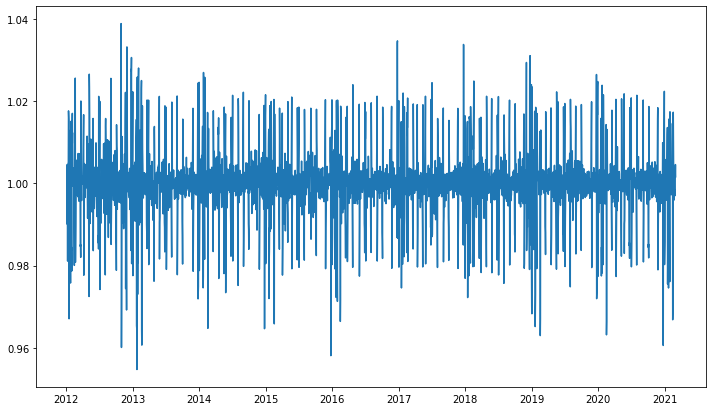

In [23]:
stationary = training["Open"] / decompose_result.trend / decompose_result.seasonal
stationary = stationary.dropna()
plt.plot(stationary)

plt.savefig("time_series_stationary.pdf", bbox_inches='tight')

In [43]:
stationary.to_csv("stationary.csv", index=False)

In [44]:
adfuller(stationary.dropna())

(-14.560116466239368,
 4.8097314196963576e-27,
 29,
 3317,
 {'1%': -3.432322977936832,
  '5%': -2.8624117455814906,
  '10%': -2.5672340478895275},
 -23645.137519876618)

# JUZ JEST STACJONARNY >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

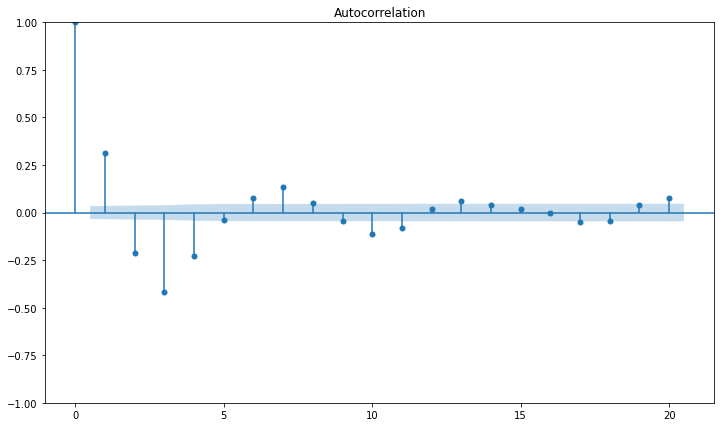

In [93]:
smgt.plot_acf(stationary, lags = 20);
plt.savefig("acf_stationary.pdf", bbox_inches='tight')

C:\Users\mateu\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


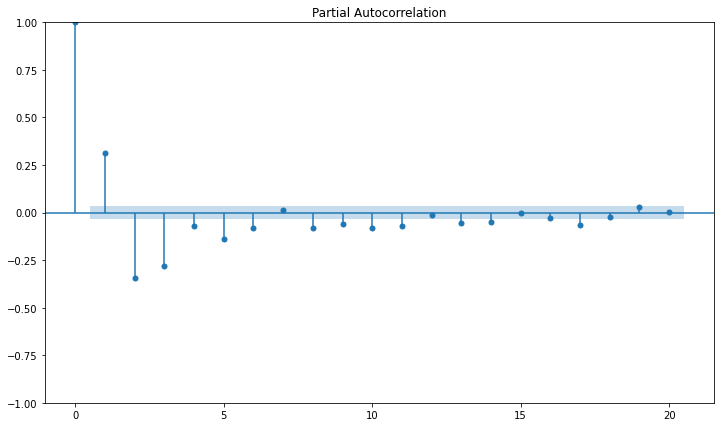

In [94]:
smgt.plot_pacf(stationary, lags = 20);
plt.savefig("pacf_stationary.pdf", bbox_inches='tight')

# Test Dickeya-Fullera

In [29]:
adfuller(stationary)

(-14.560116466239368,
 4.8097314196963576e-27,
 29,
 3317,
 {'1%': -3.432322977936832,
  '5%': -2.8624117455814906,
  '10%': -2.5672340478895275},
 -23645.137519876618)

# Dobieranie parametrów ARMA do danych

In [76]:
tests = pd.DataFrame()
ps = []
qs = []
BIC = []
AIC = []
HQIC = []

max_p = 15
max_q = 15

for p in range(0, max_p):
    for q in range(0, max_q):
        model = ARIMA(stationary, order=(p, 0, q))
        model_fit = model.fit()
        ps.append(p)
        qs.append(q)
        AIC.append(model_fit.aic)
        BIC.append(model_fit.bic)
        HQIC.append(model_fit.hqic)

tests['p']    = ps
tests['q']    = qs
tests['AIC']  = AIC
tests['BIC']  = BIC
tests['HQIC'] = HQIC
tests.sort_values(by='AIC').head()

C:\Users\mateu\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\mateu\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\mateu\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\mateu\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stati

C:\Users\mateu\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\mateu\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\mateu\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\mateu\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

C:\Users\mateu\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\mateu\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\mateu\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\mateu\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

,p,q,AIC,BIC,HQIC
127,8,7,-23236.263627,-23132.294692,-23199.073910
102,6,12,-23228.458569,-23106.142175,-23184.705960
41,2,11,-23221.194050,-23129.456754,-23188.379594
69,4,9,-23214.266239,-23122.528944,-23181.451783
111,7,6,-23214.047811,-23122.310516,-23181.233355


In [90]:
tests = pd.read_csv('row_tests_sorted.csv')

In [91]:
tests.sort_values(by='AIC')

,p,q,AIC,BIC,HQIC
0,8,7,-23236.263627,-23132.294692,-23199.073910
1,6,12,-23228.458569,-23106.142175,-23184.705960
2,2,11,-23221.194050,-23129.456754,-23188.379594
3,4,9,-23214.266239,-23122.528944,-23181.451783
4,7,6,-23214.047811,-23122.310516,-23181.233355
...,...,...,...,...,...
220,0,2,-22493.519998,-22469.056719,-22484.769476
221,0,1,-22487.843743,-22469.496284,-22481.280852
222,1,1,-22487.127843,-22462.664564,-22478.377321
223,1,0,-22339.128488,-22320.781029,-22332.565596


In [81]:
tests = tests.sort_values(by='AIC')
tests.to_csv("row_tests_sorted.csv", index=False)

In [82]:
tests.sort_values(by='BIC')

,p,q,AIC,BIC,HQIC
78,5,3,-23211.270005,-23150.111808,-23189.393701
63,4,3,-23204.619934,-23149.577557,-23184.931260
5,0,5,-23180.732054,-23137.921316,-23165.418641
19,1,4,-23179.528578,-23136.717840,-23164.215165
36,2,6,-23197.223573,-23136.065376,-23175.347269
...,...,...,...,...,...
1,0,1,-22487.843743,-22469.496284,-22481.280852
2,0,2,-22493.519998,-22469.056719,-22484.769476
16,1,1,-22487.127843,-22462.664564,-22478.377321
15,1,0,-22339.128488,-22320.781029,-22332.565596


In [83]:
tests.sort_values(by='HQIC')

,p,q,AIC,BIC,HQIC
127,8,7,-23236.263627,-23132.294692,-23199.073910
78,5,3,-23211.270005,-23150.111808,-23189.393701
41,2,11,-23221.194050,-23129.456754,-23188.379594
63,4,3,-23204.619934,-23149.577557,-23184.931260
102,6,12,-23228.458569,-23106.142175,-23184.705960
...,...,...,...,...,...
2,0,2,-22493.519998,-22469.056719,-22484.769476
1,0,1,-22487.843743,-22469.496284,-22481.280852
16,1,1,-22487.127843,-22462.664564,-22478.377321
15,1,0,-22339.128488,-22320.781029,-22332.565596


# Dobieranie parametrów ARMA do danych

In [75]:
model87 = ARIMA(stationary, order=(8, 0, 7)).fit()

print(model87v2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3347
Model:                 ARIMA(8, 0, 7)   Log Likelihood               11635.132
Date:                Thu, 09 Feb 2023   AIC                         -23236.264
Time:                        00:36:44   BIC                         -23132.295
Sample:                    01-04-2012   HQIC                        -23199.074
                         - 03-03-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9999   4.08e-05   2.45e+04      0.000       1.000       1.000
ar.L1          0.8581      0.240      3.570      0.000       0.387       1.329
ar.L2         -1.1341      0.187     -6.079      0.0

In [82]:
model53 = ARIMA(stationary - np.mean(stationary), order=(5, 0, 2)).fit()

print(model53.summary())

C:\Users\mateu\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\mateu\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3347
Model:                 ARIMA(5, 0, 2)   Log Likelihood               11553.097
Date:                Thu, 09 Feb 2023   AIC                         -23088.195
Time:                        00:50:44   BIC                         -23033.152
Sample:                    01-04-2012   HQIC                        -23068.506
                         - 03-03-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.659e-08   9.27e-05     -0.001      0.999      -0.000       0.000
ar.L1          0.1282      0.141      0.906      0.365      -0.149       0.405
ar.L2         -0.1000      0.145     -0.688      0.4

C:\Users\mateu\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [92]:
model87.params.to_list()

const    -0.000001
ar.L1     0.858062
ar.L2    -1.134057
ar.L3     0.806380
ar.L4    -0.611811
ar.L5     0.425487
ar.L6    -0.568213
ar.L7     0.526814
ar.L8    -0.187994
ma.L1    -0.616763
ma.L2     0.698685
ma.L3    -0.826536
ma.L4     0.343782
ma.L5    -0.473964
ma.L6     0.521004
ma.L7    -0.376714
sigma2    0.000056
dtype: float64

# RESIDUAAAA

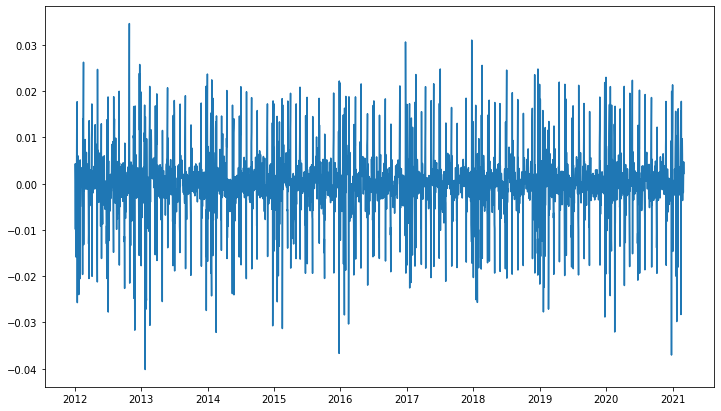

In [71]:
plt.plot(model87.resid)

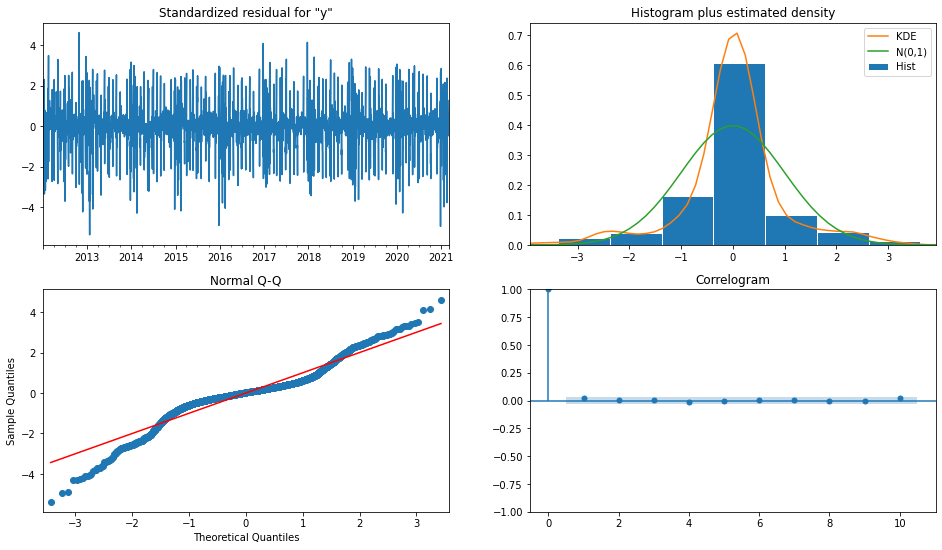

In [112]:
model87.plot_diagnostics(0,figsize=(16,9))
plt.plot();
plt.savefig("residuals.pdf", bbox_inches='tight')

In [148]:
mu = np.mean(model87.resid)
mu

4.573884065569047e-06

In [149]:
var = np.var(model87.resid)
var

5.60074649212285e-05

In [155]:
ax = np.arange(-0.04,0.04,0.001)

<AxesSubplot:ylabel='Density'>

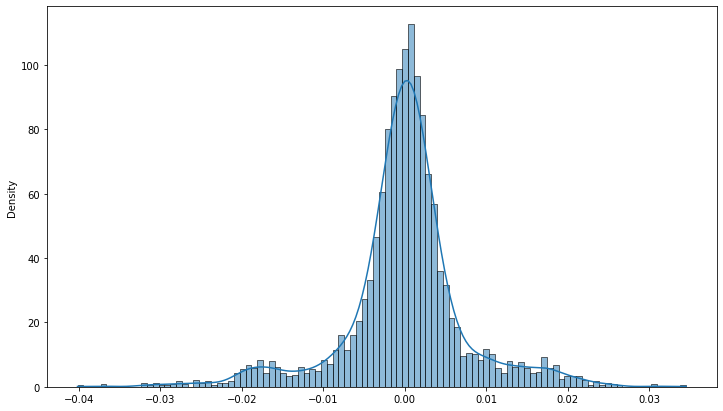

In [156]:
sns.histplot(data=model87.resid, stat="density", kde=True)

<AxesSubplot:ylabel='Density'>

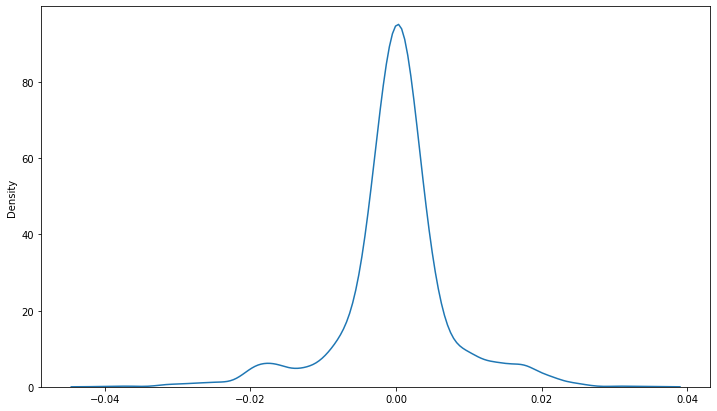

In [157]:
sns.kdeplot(model87.resid)

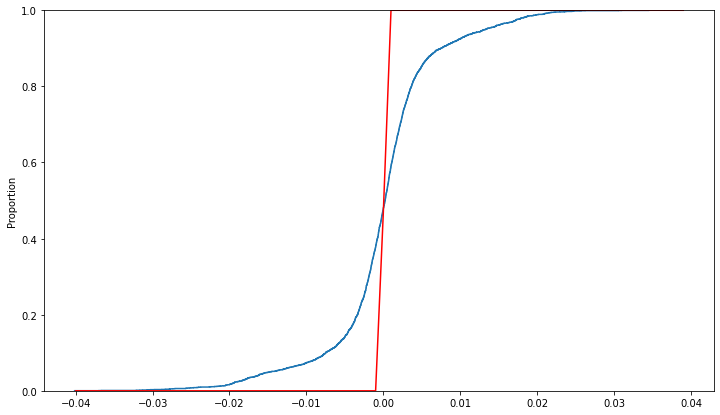

In [160]:
sns.ecdfplot(model87.resid, label="empiryczna")
plt.plot(ax, scipy.stats.norm.cdf(ax,mu,var), c='r', label="teoretyczna")